### 4.5.2 高维线性回归

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones([num_inputs, 1]) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.3 从零开始实现

In [4]:
def init_params():
    w = torch.normal(0, 1, size=[num_inputs, 1], requires_grad=True)
    b = torch.zeros([1], requires_grad=True)
    return w, b

In [5]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)  # 在这里面进行求平均

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, [d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)])
    print(f'w的L2范数是: {torch.norm(w).item()}')

忽略正则化直接训练

w的L2范数是: 15.442132949829102


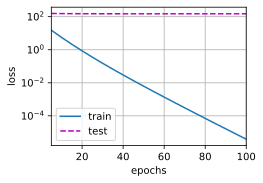

In [7]:
train(0)

使用权重衰减

w的L2范数是: 0.395134299993515


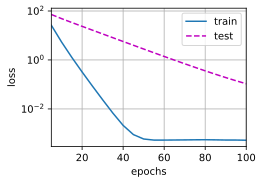

In [8]:
train(3)

### 4.5.4 简洁实现

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003

    trainer = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': wd},
        {"params": net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, [d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)])
    print(f'w的L2范数是: {net[0].weight.norm().item()}')
    return net

w的L2范数是: 13.82852554321289


Sequential(
  (0): Linear(in_features=200, out_features=1, bias=True)
)

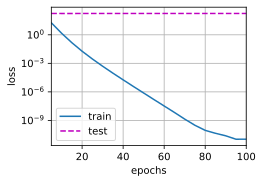

In [14]:
train_concise(0)

w的L2范数是: 0.3540723919868469


Sequential(
  (0): Linear(in_features=200, out_features=1, bias=True)
)

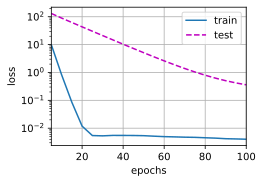

In [15]:
train_concise(3)

绘制训练精度和测试精度关于λ的函数图

In [ ]:
loss = nn.MSELoss(reduction='none')
final_loss = []

for i in range(50):
    net = train_concise(i)
    final_loss.append([d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)])

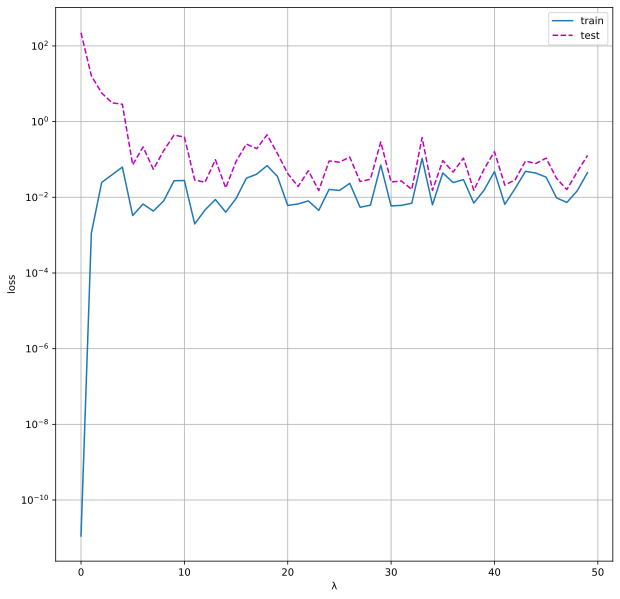

In [13]:
d2l.plot(list(range(50)), list(zip(*final_loss)), 'λ', 'loss', ['train', 'test'], figsize=[10, 10], yscale='log')